# VECs - Cell Rank - Trajectory Inference - scCLEAN


Goal: Do Vascular Endothelial Cells (VEC) express a similar seperation in lineage differentiation?
   
While Vascular Smooth Muscle cells (VSMCs) show high phenotypic plasticity, we would not expect VECs to show a similar ability to differentiate into multiple states

1 - perform Cell Rank according to tutorials: https://cellrank.readthedocs.io/en/stable/index.html

2 - How many lineages are idenitifed?

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scFates as scf

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo", dpi_save=700)
cr.settings.verbosity = 2


In [2]:
#open the filtered batch corrected anndata matrix 
#samples underwent QC individually, and then aggregated using 'pegasus aggregate_matrix' CLI
#See notebook for identification of Force Directed Layout Trajectory graphs
adata = sc.read_h5ad('VEC/miQC/subtypes_Depleted_VEC_all_patients.h5ad')
adata

AnnData object with n_obs × n_vars = 23413 × 15535
    obs: 'n_genes', 'n_counts', 'percent_mito', 'Channel', 'scale', 'louvain_labels', 'Tissue', 'doublet_score', 'pred_dbl', 'splice', 'value'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'PCs', '_attr2type', 'diffmap_evals', 'genome', 'louvain_labels_colors', 'louvain_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'diffmap_knn_distances', 'diffmap_knn_indices', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices'
    varm: 'means', 'partial_sum'
    obsp: 'W_diffmap', 'W_pca_harmony'

In [3]:
adata.obs

,n_genes,n_counts,percent_mito,Channel,scale,louvain_labels,Tissue,doublet_score,pred_dbl,splice,value
barcodekey,,,,,,,,,,,
P1_Coronary-AAACCCAAGCCGATCC,4468,12636,0.039569,P1_Coronary,7.915150,4,Coronary,0.000891,False,Yes,0
P1_Coronary-AAACCCAAGCCGGAAT,5580,18909,0.042308,P1_Coronary,5.288767,3,Coronary,0.000731,False,Yes,0
P1_Coronary-AAACCCAAGGAGTCTG,5801,21070,0.033223,P1_Coronary,4.746310,3,Coronary,0.000428,False,Yes,0
P1_Coronary-AAACCCAGTATTCCTT,6155,25454,0.027501,P1_Coronary,3.928656,1,Coronary,0.000567,False,Yes,0
P1_Coronary-AAACCCAGTGGCACTC,5382,17229,0.040629,P1_Coronary,5.804167,1,Coronary,0.000428,False,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...
P2_Pulmonary-TTTGTTGGTGCCCGTA,4872,19192,0.005211,P2_Pulmonary,5.210504,1,Pulmonary,0.000737,False,Yes,0
P2_Pulmonary-TTTGTTGGTGTGACCC,4248,11166,0.035823,P2_Pulmonary,8.955759,4,Pulmonary,0.000401,False,Yes,0
P2_Pulmonary-TTTGTTGTCATCTATC,5071,18318,0.005459,P2_Pulmonary,5.459707,1,Pulmonary,0.000659,False,Yes,0


In [4]:
#check the proportion of tissues within this dataset
adata.obs['Tissue'].value_counts()

Pulmonary    12986
Coronary     10427
Name: Tissue, dtype: int64

In [5]:
adata.uns['Tissue_colors']= np.array(['#BA0900', '#809693'], dtype=object)

In [6]:
#need to use the harmony batch integrated matrix
sc.pp.neighbors(adata, use_rep='X_pca_harmony')


In [7]:
# see Cell Rank tutorial "CellRank beyond RNA velocity"
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
#30 and 30 
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:35) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata)

Computing CytoTRACE score with `15535` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:09)


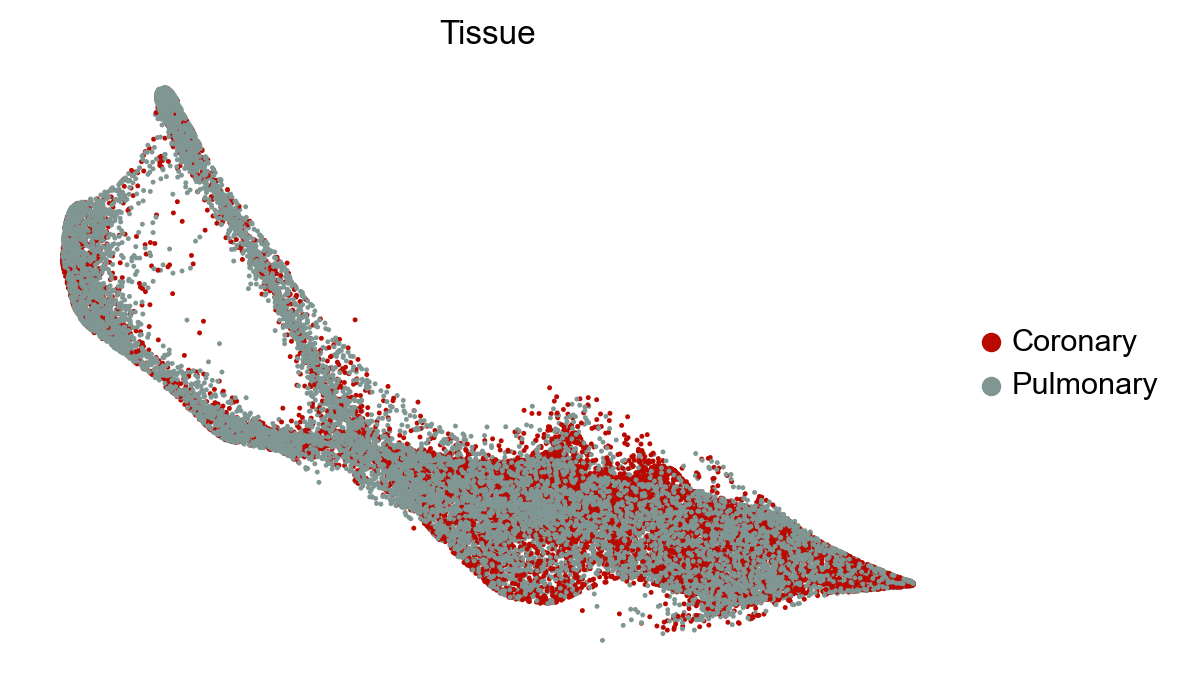

In [9]:
#plotting using scvelo functions
scv.pl.scatter(adata, basis="fle", color="Tissue", legend_loc="right")

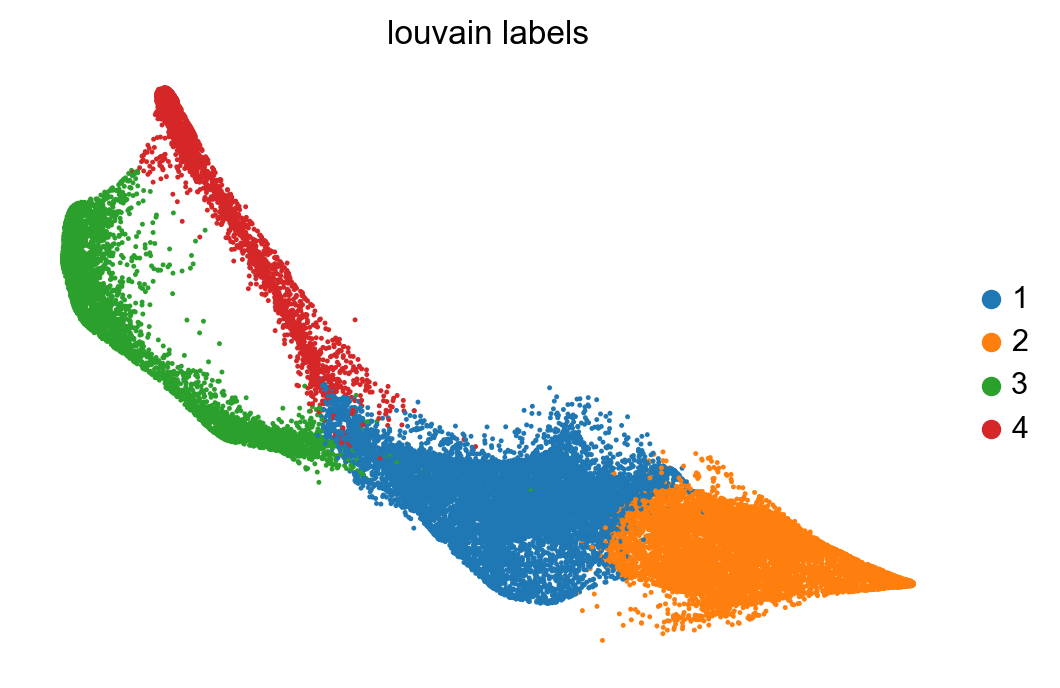

In [10]:
#plotting using scvelo functions
scv.pl.scatter(adata, basis="fle", c="louvain_labels", legend_loc="right")

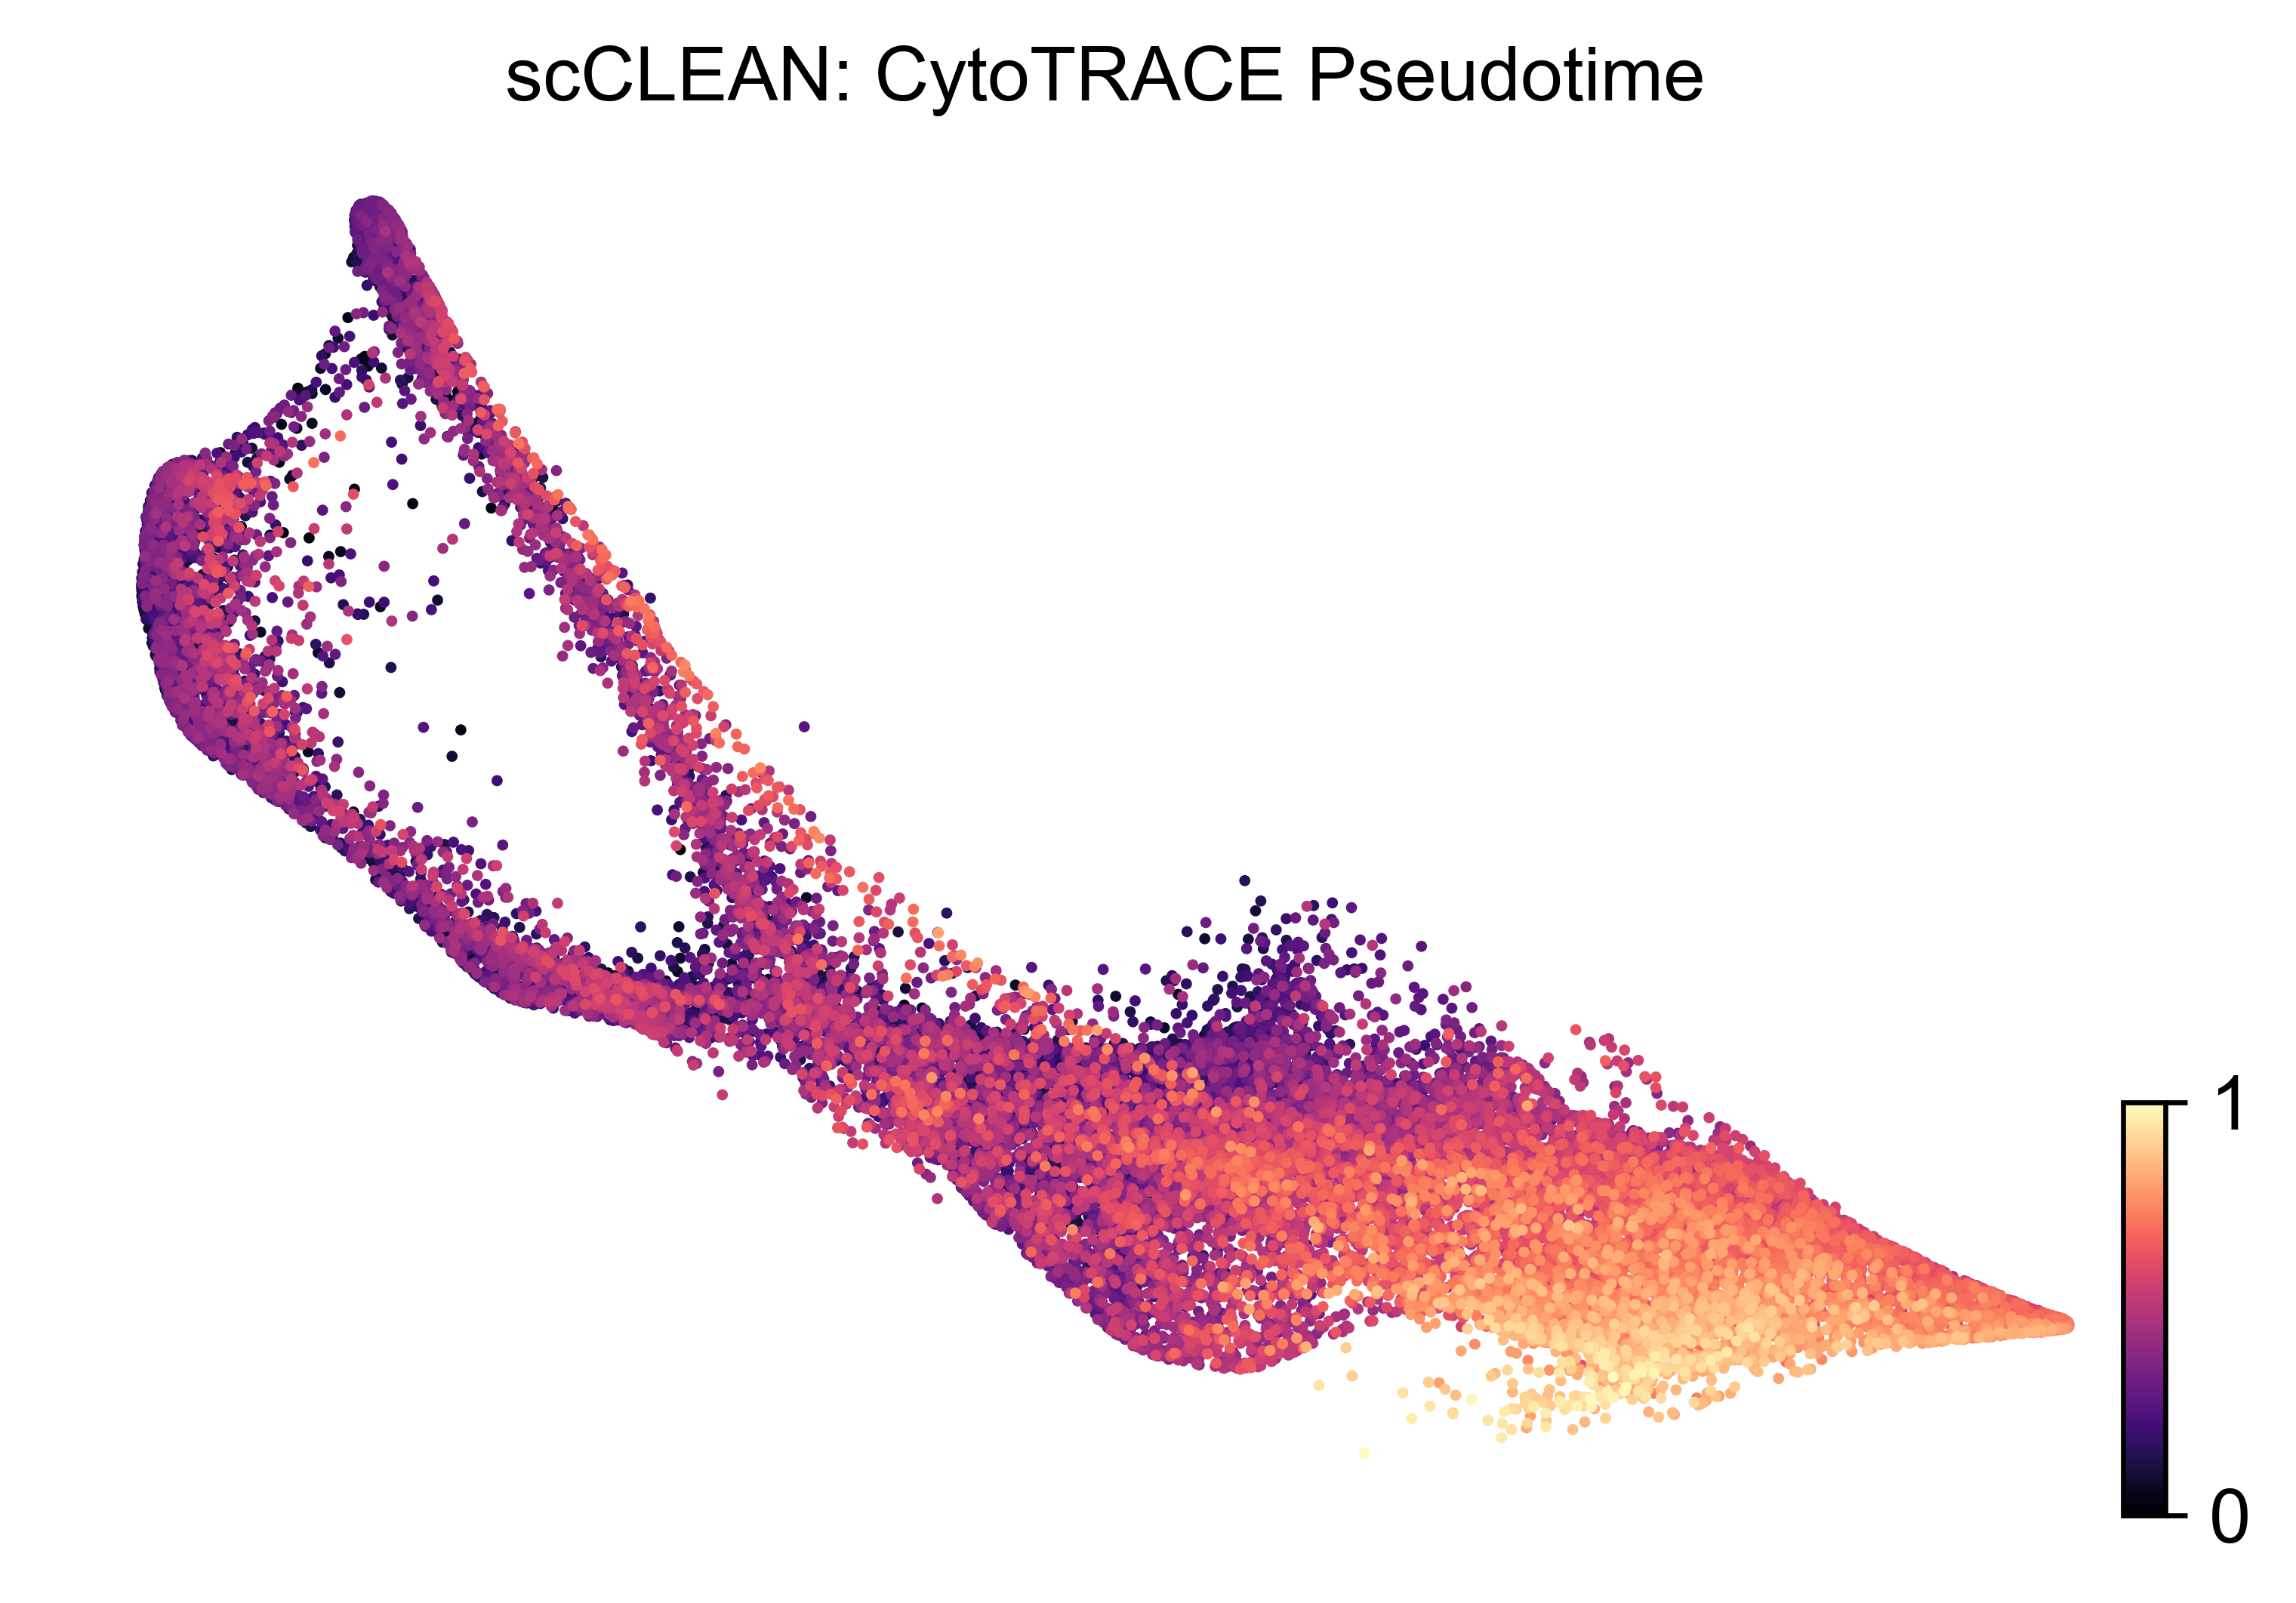

In [11]:
#plotting using scvelo functions
scv.pl.scatter(adata, basis="fle", c="ct_pseudotime", legend_loc="right",cmap='magma',
              title='scCLEAN: CytoTRACE Pseudotime', dpi=300)

In [12]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.3)

Computing transition matrix based on `ct_pseudotime`


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 23413/23413 [00:04<00:00, 4914.40cell/s]


    Finish (0:00:10)


<CytoTRACEKernel>

In [13]:
from cellrank.tl.estimators import GPCCA

g_fwd = GPCCA(ctk)
print(g_fwd)

GPCCA[n=23413, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.3]>]


Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999933e-01 -2.1332979972031804e-02 -4.3069503619686582e-02 -3.0194273241957850e-02 8.0349215057147205e-02 -1.5179927032817196e-02 -3.3788071879661527e-02 -1.8057218913019400e-02 9.5900233465975052e-02 3.6046699912602884e-02 -3.7040495654365416e-02 1.4887202995517818e-02 1.4351403705466944e-02 1.1421117215230406e-02 -2.3668488360514391e-02 -1.7515753205538796e-02 2.5944148024221532e-03 -5.7308990803524140e-02 3.0460670368235750e-02 2.1626124942813147e-02 -1.8622598391411293e-02 2.9232102407401268e-02 1.1393566238821292e-02 5.6867404289678819e-02 -1.4920083645526369e-02 
0.0000000000000000e+00 9.5666182396475385e-01 -1.2856216548113798e-02 -9.8780578862895665e-02 4.5335215810748883e-02 1.0463839220245245e-01 2.0575951632507149e-02 5.9451046851428362e-03 -4.9665932951521441e-02 4.3297549532138775e-02 -2.2802418819933227e-02 2.3071482911995317e-02 -1.6241751493539042e-02 3.0844800443148076e-02 2.02028795

Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


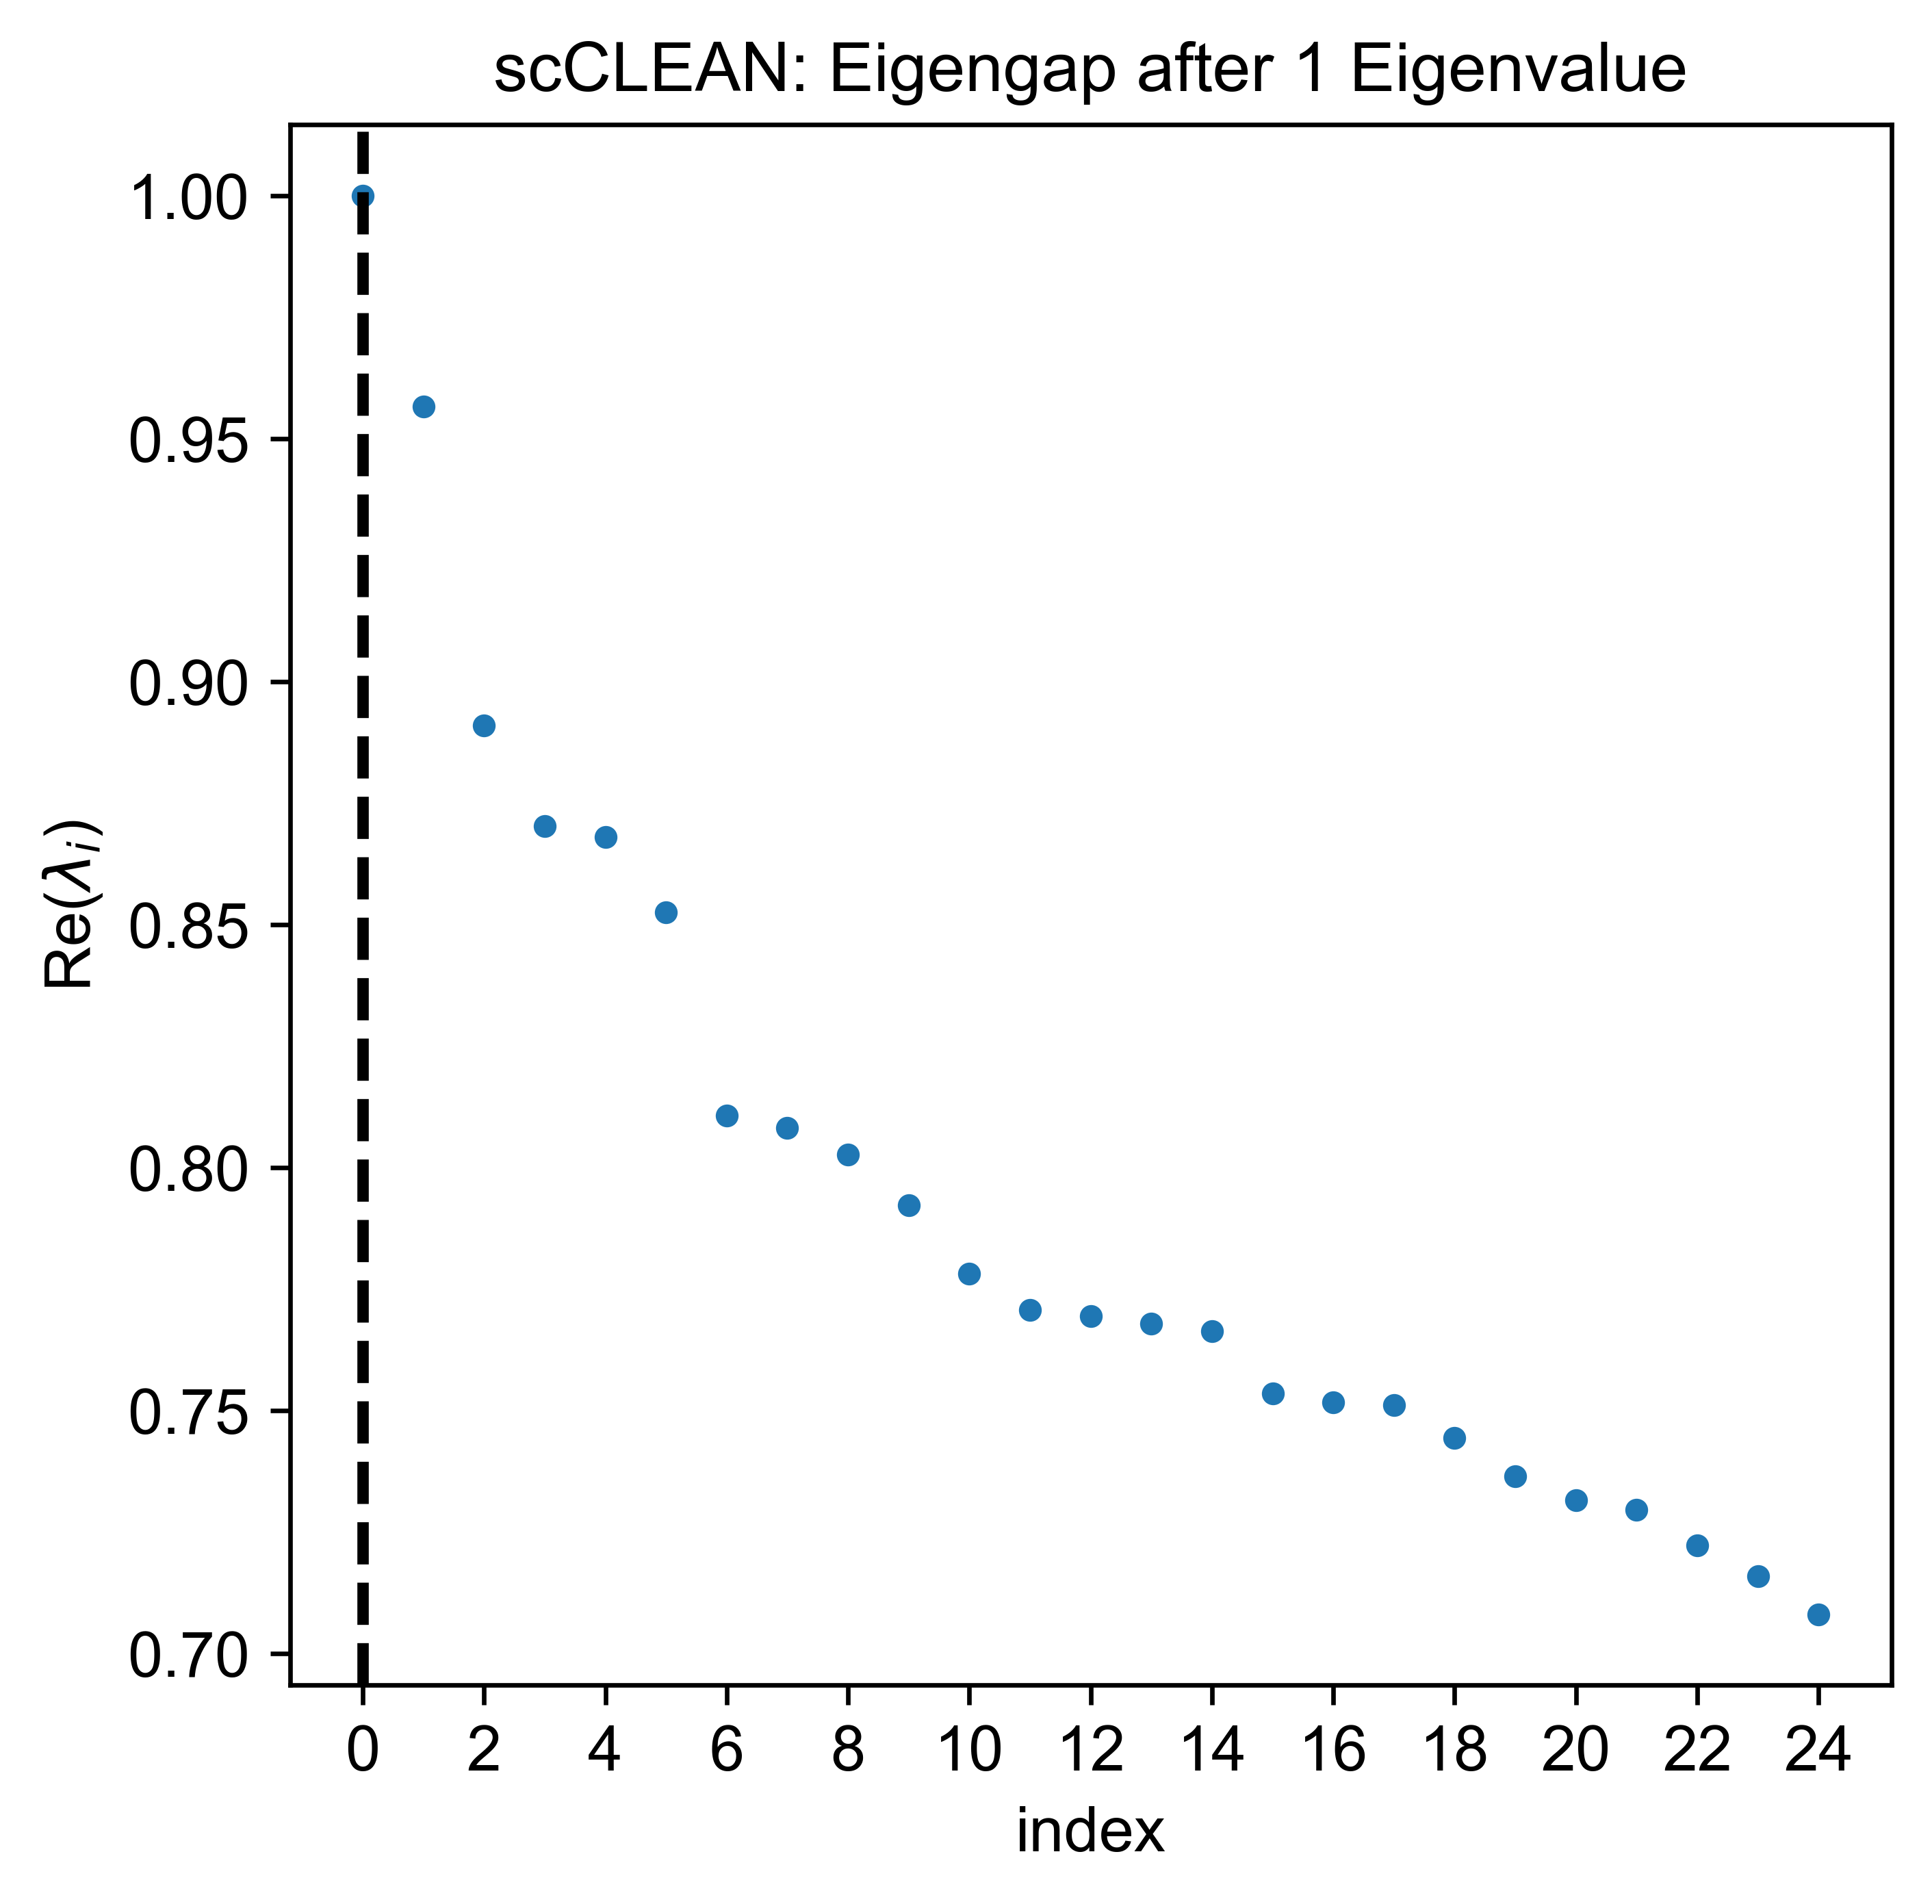

In [16]:
g_fwd.compute_schur(n_components=25, alpha=0.8)
g_fwd.plot_spectrum(real_only=True, title='scCLEAN: Eigengap after 1 Eigenvalue', dpi=300,show_all_xticks=False)

According to the gap in the real component of the eigenvalues, one mcarostate should be computed

It is clear that there is only 1 macrostate identified within this cohort, which matches our hypothesis considering it is one distinct cell type (VECs) that do not show the same level of plasticity 

For 1 macrostate, stationary distribution is computed
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:02)
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


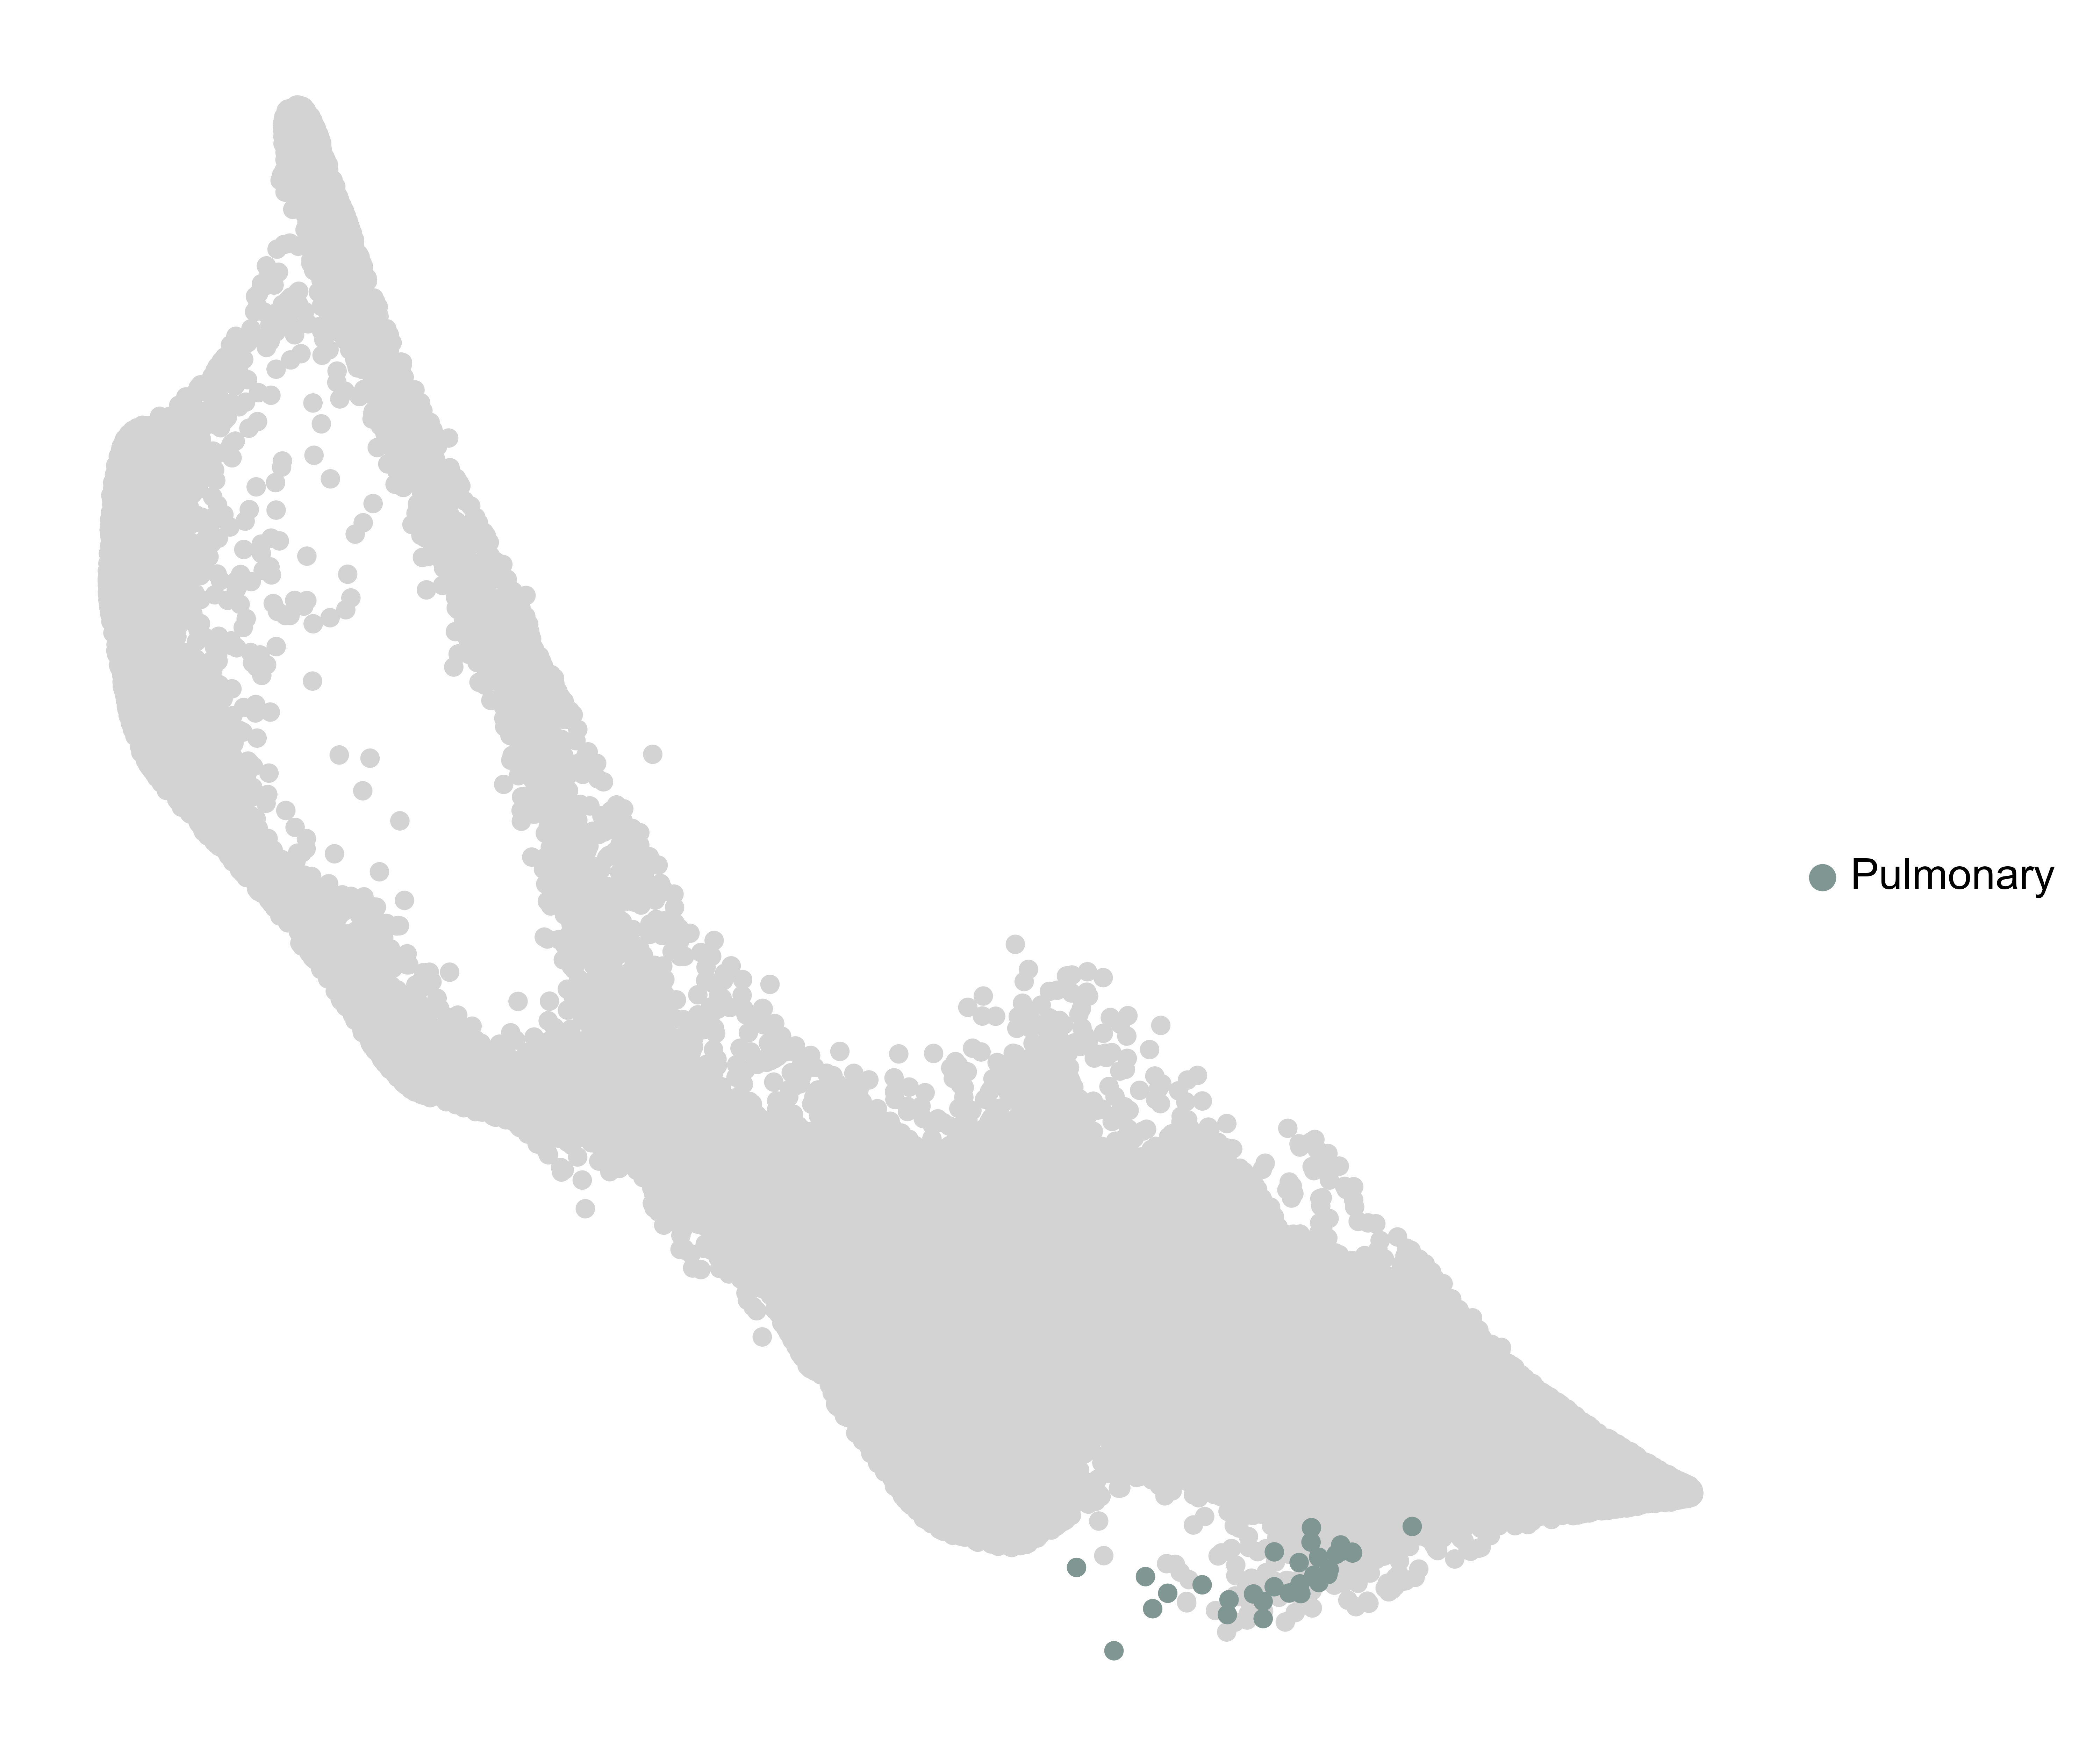

In [18]:
#cluster_key tries to associate the names of macrostates with cluster labels, 
#or in this case, tissue origin
g_fwd.compute_macrostates(n_states=1, cluster_key="Tissue")
g_fwd.plot_macrostates(
    discrete=True, legend_loc="right", size=100, basis="fle", title='',
    figsize=[8,8], dpi=400)

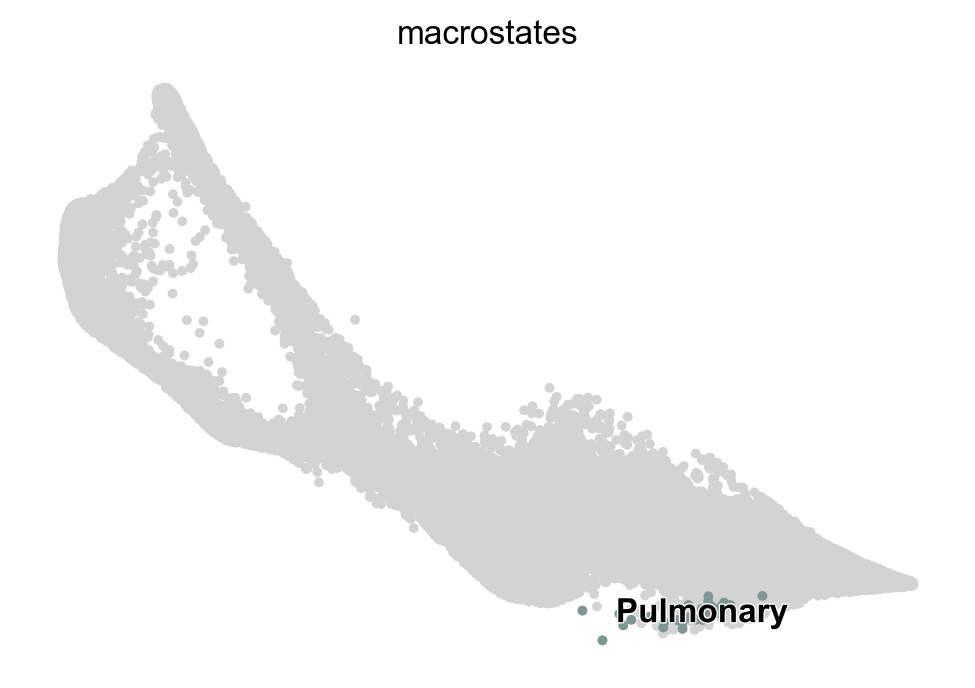

In [49]:
g_fwd.plot_macrostates(discrete=True, same_plot=True, basis="fle", size=50)

In [19]:
#add a new observale into adata.obs defining the terminal states
g_fwd.set_terminal_states_from_macrostates(names=["Pulmonary"])


Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


In [20]:
g_fwd.rename_terminal_states({'Pulmonary':'Lineage 1'})

Computing absorption probabilities


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30/s]

Adding `adata.obsm['to_terminal_states']`
       `adata.obsm['absorption_times_fwd']`
       `.absorption_probabilities`
       `.absorption_times`
    Finish (0:00:00)


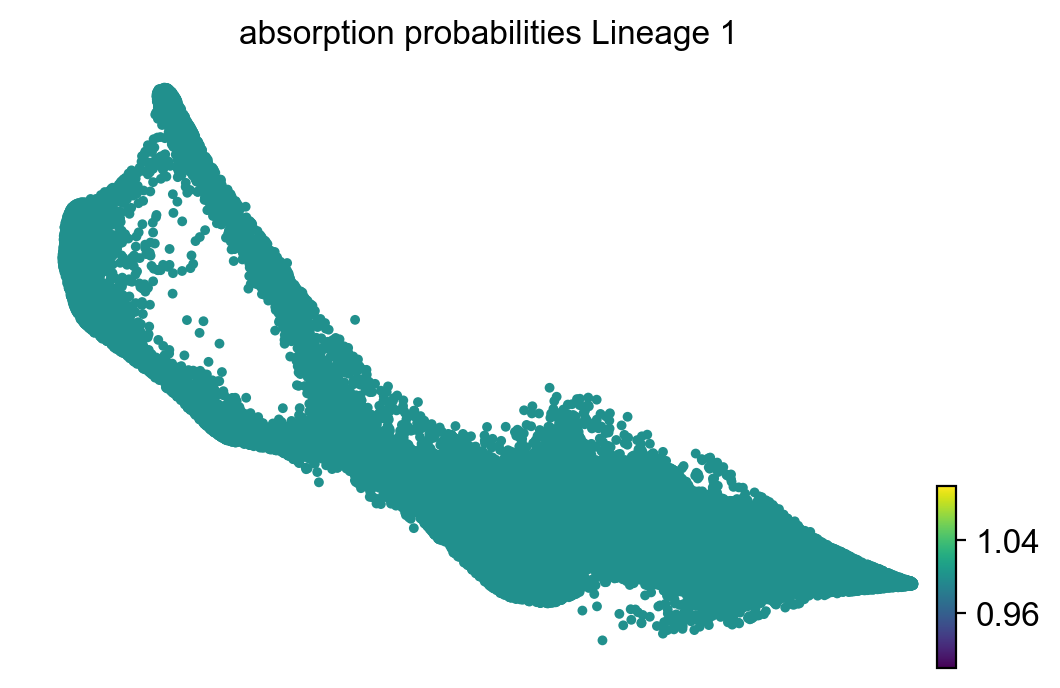

In [21]:
#this computes the fate probabilities toward those terminal states for every cell
g_fwd.compute_absorption_probabilities(time_to_absorption='all')
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="fle")

In [22]:
adata.uns['terminal_states_colors']= np.array(['#CF9FFF', '#DA70D6'], dtype=object)

saving figure to file VEC/PC_figures/Depleted_VEC_lineage.png


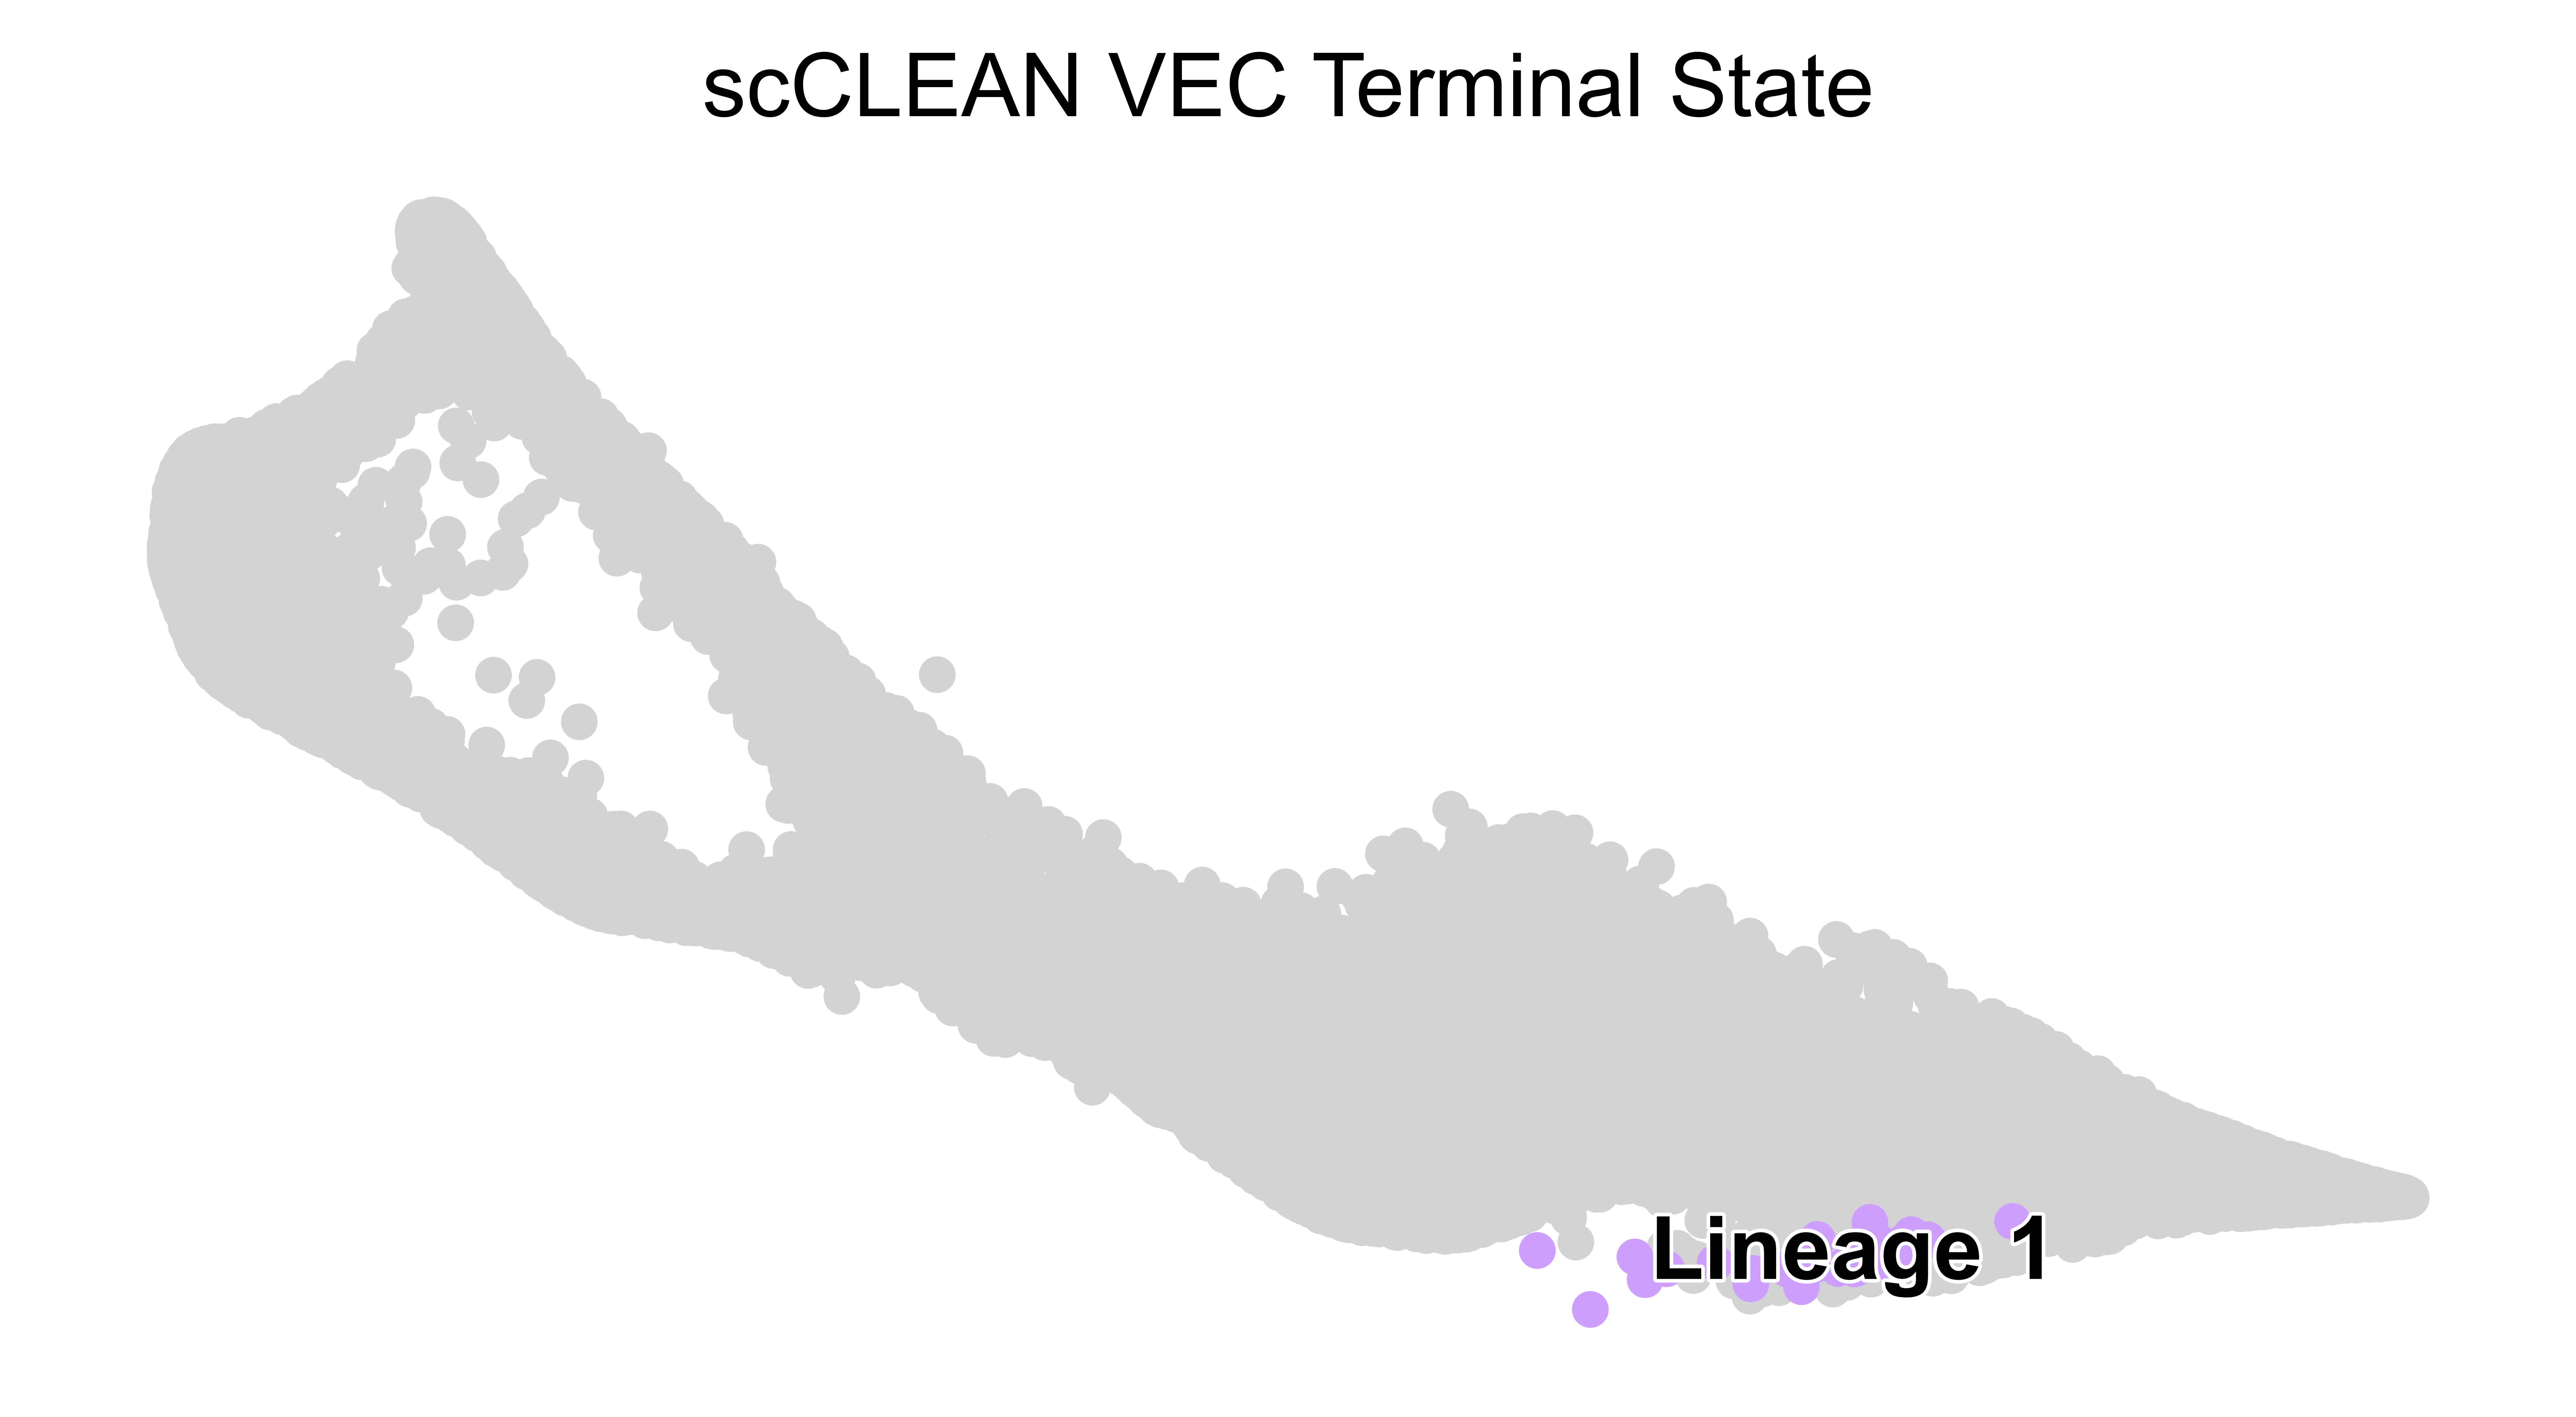

In [23]:
scv.pl.scatter(adata, basis="fle", c="terminal_states", legend_loc='on data', size=100
               , title='scCLEAN VEC Terminal State', dpi=800, figsize=[6,3],
               save='VEC/PC_figures/Depleted_VEC_lineage.png')